In [1]:
!where python

C:\Users\okatk\AppData\Local\Programs\Python\Python311\python.exe
C:\Users\okatk\AppData\Local\Microsoft\WindowsApps\python.exe


In [2]:
!C:\Users\okatk\AppData\Local\Programs\Python\Python311\python.exe -m pip install scanpy



In [3]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize  # example for CLR, but might need to implement manually
import besca as bc
import seaborn as sns



C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scvi\_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scvi\_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using

In [4]:
!pip install louvain



C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning:

unclosed file <_io.BufferedWriter name=3>

C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning:

unclosed file <_io.BufferedReader name=4>

C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning:

unclosed file <_io.BufferedReader name=5>



In [5]:
# load in files 
adata = sc.read(r"C:\Users\okatk\OneDrive - Tredyffrin Easttown School District\Drexel Research\raw_protein (1).h5ad")

# Display the first few rows of data to verify successful loading
adata.obs.head()


C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.



,batch
AAACCTGAGAAGCCCA-1,lib1
AAACCTGAGACTAAGT-1,lib1
AAACCTGAGAGAACAG-1,lib1
AAACCTGAGAGGGATA-1,lib1
AAACCTGAGATACACA-1,lib1


In [6]:
# 1. Calculate the percentage of mitochondrial counts for each cell (assuming you still want to do this for protein data)

# Find the mitochondrial genes
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]

# Calculate the percentage of mitochondrial UMIs for each cell
# Ensure data is in array format
adata_X_array = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
adata.obs['percent_mito'] = np.sum(adata_X_array[:, [adata.var_names.get_loc(gene) for gene in mito_genes]], axis=1) / np.sum(adata_X_array, axis=1)

# 2. Filter out cells based on the given criteria

# Percentage of mitochondrial counts > 15%
mito_filter = adata.obs['percent_mito'] > 0.15

# Number of unique features or total counts in the bottom or top 0.5% of all cells
n_counts = np.sum(adata_X_array, axis=1)
n_features = np.sum(adata_X_array > 0, axis=1)

lower_bound_counts = np.percentile(n_counts, 0.5)
upper_bound_counts = np.percentile(n_counts, 99.5)
lower_bound_features = np.percentile(n_features, 0.5)
upper_bound_features = np.percentile(n_features, 99.5)

counts_filter = (n_counts < lower_bound_counts) | (n_counts > upper_bound_counts)
features_filter = (n_features < lower_bound_features) | (n_features > upper_bound_features)

# Number of unique features < 50
features_50_filter = n_features < 50

# Combining all filters
combined_filter = mito_filter | counts_filter | features_50_filter

# Filter the data
adata_filtered = adata[~combined_filter]

print(f"Remaining cells: {adata_filtered.shape[0]}, Original number of cells: {adata.shape[0]}")


Remaining cells: 86365, Original number of cells: 87238


In [7]:
# This cell will reiterate over the data, calculate necessary metrics, and store them in the AnnData object's observations (adata.obs)

# Recalculate metrics based on the filtered dataset
adata_filtered_X_array = adata_filtered.X.toarray() if hasattr(adata_filtered.X, "toarray") else adata_filtered.X

# Calculate and store total counts for each cell in adata.obs
adata_filtered.obs['n_counts'] = np.sum(adata_filtered_X_array, axis=1)

# Calculate and store number of unique features per cell in adata.obs
adata_filtered.obs['n_features'] = np.sum(adata_filtered_X_array > 0, axis=1)

# Output the shape of the filtered dataset for verification
print(f"Remaining cells after filtering: {adata_filtered.shape[0]}, Original number of cells: {adata.shape[0]}")


Remaining cells after filtering: 86365, Original number of cells: 87238


C:\Users\okatk\AppData\Local\Temp\ipykernel_10076\1721550169.py:7: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.



In [8]:
# 1. Normalize the protein counts to the same total counts per cell
sc.pp.normalize_total(adata_filtered, target_sum=1e4)

# 2. Log-transform the data (natural log transformed after the addition of a pseudocount of 1)
sc.pp.log1p(adata_filtered)

# 3. Scale the data and regress out specified variables
# As G2M and S phase scores aren't available in your dataset, we'll regress out only n_features and percent_mito.
sc.pp.regress_out(adata_filtered, ['n_features', 'percent_mito'])

# After regressing out, scale the data
sc.pp.scale(adata_filtered, max_value=10, zero_center=True)

# Note: As the entire dataset is protein data, we don't have a separate protein layer.
# Therefore, we skip the CLR normalization step.


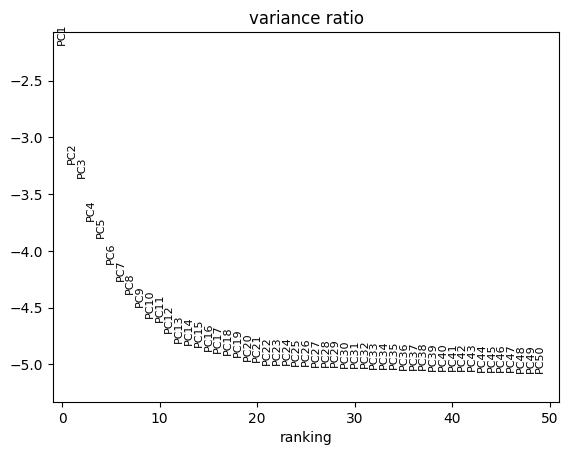

C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:163: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

C:\Users\okatk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



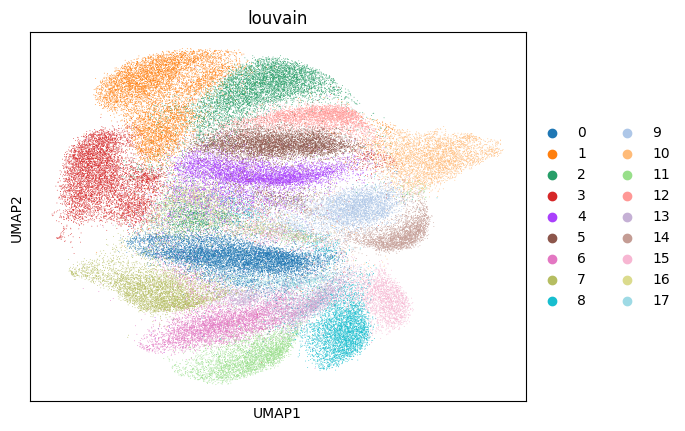

In [9]:
# If you have multiple datasets to integrate, you can use bbknn or mnn_correct. 
# If not, skip this step.
# integrated = sc.external.pp.bbknn(adata, batch_key='batch')
# adata = integrated

# Compute the PCA
sc.tl.pca(adata_filtered)

# Decide on the number of PCs based on the explained variance plot
sc.pl.pca_variance_ratio(adata_filtered, log=True, n_pcs=50)

# Assuming you chose, for example, 20 PCs:
n_pcs = 20

# Compute neighbors (equivalent to constructing the WNN graph in Seurat)
sc.pp.neighbors(adata_filtered, n_pcs=n_pcs)

# Compute UMAP coordinates for visualization
sc.tl.umap(adata_filtered)

# Cluster the cells using the Louvain algorithm
sc.tl.louvain(adata_filtered)

# Visualize the clusters using UMAP
sc.pl.umap(adata_filtered, color='louvain')


In [11]:
# Define the isotype controls based on the gene names from the Excel file
isotype_controls_gene_names = ["CD", "CD274", "CD270", "CD155", "CD112", "CD47", "CD48"]

all_protein_names = adata_filtered.var_names

# Check if these gene names exist in the dataset
available_isotypes = [protein for protein in all_protein_names for gene in isotype_controls_gene_names if gene in protein]


num_isotypes = len(available_isotypes)


num_clusters = adata_filtered.obs['louvain'].nunique() if 'louvain' in adata_filtered.obs.columns else 0

print(num_isotypes)

print(num_clusters)


118
18


In [12]:
medians = np.median(adata_filtered[:, available_isotypes].X, axis=0)
mad_values = np.median(np.abs(adata_filtered[:, available_isotypes].X - medians), axis=0)
thresholds = medians + 2 * mad_values  # You can adjust the factor (2 in this case) based on your requirements


In [18]:
# 1. Flag cells based on thresholds
flags = (adata_filtered[:, available_isotypes].X > thresholds)

# 2. Summarize flags per cell
num_flags_per_cell = flags.sum(axis=1)

# 3. Annotate cells in the adata object
adata_filtered.obs['num_isotype_flags'] = num_flags_per_cell

# Optional: Filter out cells that exceed thresholds for multiple isotype controls (e.g., more than 2)
#to_keep = num_flags_per_cell <= 2
#adata_filtered = adata_filtered[to_keep]



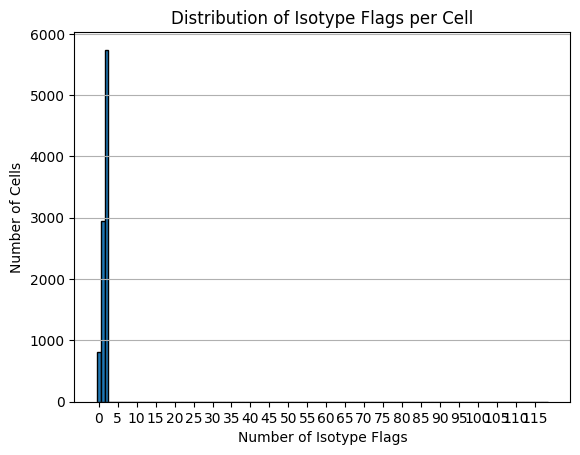

In [19]:
plt.hist(adata_filtered.obs['num_isotype_flags'], bins=np.arange(0, len(available_isotypes) + 2) - 0.5, edgecolor='k')
plt.xlabel('Number of Isotype Flags')
plt.ylabel('Number of Cells')
plt.title('Distribution of Isotype Flags per Cell')

# Set the x-ticks to display every other value (or change the 2 to another number to adjust frequency)
ticks = np.arange(0, len(available_isotypes) + 1, 5)
plt.xticks(ticks, ticks)

plt.grid(axis='y')
plt.show()


In [20]:
def clr_normalize(data):
    # Add a small constant to avoid log(0)
    data_with_pseudocount = data + 1e-10
    
    # Compute log-transformed values
    log_data = np.log(data_with_pseudocount)
    
    # Calculate the geometric mean for each cell
    geometric_mean = np.mean(log_data, axis=1, keepdims=True)
    
    # Subtract the geometric mean from the log-transformed values
    clr_data = log_data - geometric_mean
    
    return clr_data

# Apply CLR normalization on your data
adata_filtered.X = clr_normalize(adata_filtered.X)


C:\Users\okatk\AppData\Local\Temp\ipykernel_10076\982005143.py:6: RuntimeWarning:

invalid value encountered in log



In [25]:
# List of all antibody names (replace this with your actual antibody names)
antibodies = [
    'TotalSeq-C0251 anti-human Hashtag 1 Antibody',
    'TotalSeq-C0252 anti-human Hashtag 2 Antibody',
    'TotalSeq-C0253 anti-human Hashtag 3 Antibody',
    'TotalSeq-C0254 anti-human Hashtag 4 Antibody',
    'TotalSeq-C0255 anti-human Hashtag 5 Antibody',
    'TotalSeq-C0256 anti-human Hashtag 6 Antibody',
    'TotalSeq-C0257 anti-human Hashtag 7 Antibody',
    'TotalSeq-C0258 anti-human Hashtag 8 Antibody',
    'TotalSeq-C0259 anti-human Hashtag 9 Antibody',
    'TotalSeq-C0260 anti-human Hashtag 10 Antibody',
    'TotalSeq-C0262 anti-human Hashtag 12 Antibody',
    'TotalSeq-C0263 anti-human Hashtag 13 Antibody'
]

# Check which antibodies are in your dataset
available_antibodies = [ab for ab in antibodies if ab in adata_filtered.var_names]

if not available_antibodies:
    print("None of the provided antibodies are in the dataset.")
else:
    # Define thresholds for each available antibody based on median expression levels
    thresholds = {ab: np.median(adata_filtered[:, ab].X) for ab in available_antibodies}

    # Annotate cells based on these thresholds
    for ab, threshold in thresholds.items():
        binding_cells = adata_filtered[:, ab].X > threshold
        adata_filtered.obs[f'{ab}_binding'] = binding_cells.astype(int)

    print(f"Cells annotated for antibodies: {', '.join(available_antibodies)}")


Cells annotated for antibodies: TotalSeq-C0251 anti-human Hashtag 1 Antibody, TotalSeq-C0252 anti-human Hashtag 2 Antibody, TotalSeq-C0253 anti-human Hashtag 3 Antibody, TotalSeq-C0254 anti-human Hashtag 4 Antibody, TotalSeq-C0255 anti-human Hashtag 5 Antibody, TotalSeq-C0256 anti-human Hashtag 6 Antibody, TotalSeq-C0257 anti-human Hashtag 7 Antibody, TotalSeq-C0258 anti-human Hashtag 8 Antibody, TotalSeq-C0259 anti-human Hashtag 9 Antibody, TotalSeq-C0260 anti-human Hashtag 10 Antibody, TotalSeq-C0262 anti-human Hashtag 12 Antibody, TotalSeq-C0263 anti-human Hashtag 13 Antibody


In [26]:
# Count the number of positive antibodies for each cell
adata_filtered.obs['num_positive_antibodies'] = adata_filtered[:, antibodies].X.sum(axis=1)

# Annotate cells with only one positive antibody
single_positive_cells = (adata_filtered.obs['num_positive_antibodies'] == 1)
for ab in antibodies:
    specificity_column_name = f'{ab}_specificity'
    adata_filtered.obs[specificity_column_name] = 0
    adata_filtered.obs.loc[single_positive_cells & adata_filtered.obs[ab + '_binding'], specificity_column_name] = 1

# Remove the intermediate column
adata_filtered.obs.drop('num_positive_antibodies', axis=1, inplace=True)


In [32]:
# Determine cells with no positive antibodies or multiple positive antibodies
no_binding_cells = (adata_filtered.obs.filter(like='_binding').sum(axis=1) != 1)

# Annotate these cells as nonbinding in the adata object
adata_filtered.obs['nonbinding'] = no_binding_cells.astype(int)

# If you want a count of nonbinding cells:
num_nonbinding_cells = no_binding_cells.sum()
print(f"Number of nonbinding cells: {num_nonbinding_cells}")


Number of nonbinding cells: 9502
